## **70010 - Computational Neurodynamics: Coursework**
### Vincent , Ginevra Cepparulo, Asia Belfiore
---

Write  Python  code  that  will  generate  **small-world  modular  networks**  of  *Izhikevich 
neurons*:
* Follow the rewiring procedure described in the Modular Networks Topic.  
* For  network  construction,  follow  the  description  of the experiment in Dynamical Complexity Topic. 

**NB:** the networks need a separate inhibitory  population: use  the  neuron  parameters  from  the  earlier  lecture  notes  for excitatory and inhibitory Izhikevich neurons. 

You can use the IzNetwork class from Exercise 2. 
  
---
  
Generate  a  network  for  each  of  the  following  values  of  p:  p  =  0,  p  =  0.1,  p  =  0.2,  p  = 
0.3, p = 0.4, and p = 0.5. For each of these networks: 
 
Your results should be consistent with those in the slides.

In [3]:
from iznetwork import IzNetwork
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class Small_World_Modular_Net(object):
    """
    Small World Modular Network defined by:
        - the number of nodes n
        - number of edges m
        - number of modules C
        - probability of rewiring p
    """

    def __init__(self, p, n=1000, m=1000, C=8):
        """
        -----
        Inputs:
            _    -- __________

            _    -- ___________

        """
        # network parameters
        self._num_neurons = n
        self._D = np.zeros((n, n)) # Initialize Delays
        self._W = np.zeros((n, n)) # Initialize Weight Connections

        # indices of each neuron type
        self._excitatory = [i for i in range(int(n * 0.8))] # indices [0,800) = excitatory neurons
        inhibitory_offset = len(self._excitatory)
        self._inhibitory = [(i + inhibitory_offset) for i in range(int(n * 0.2))] # indices [800,1000) = excitatory neurons

        # connection matrix nxn: each (n_i, n_j) entry represents the directed connection from neuron i to neuron j
        self._connections = np.zeros((n, n))

        # C communities of n//C neurons, where each entry (C_k, n_i, n_j) represents the edge from the i-th to the j-th excitatory neurons in k-th community 
        # EG: (3, 307, 385) = 1, if the 307th neuron in 3rd community conects to the 385th neuron in the same community
        #     (3, 307, 385) = 0, otherwise  
        neuro_per_module = self._excitatory//C
        self._num_modules = C
        self._communities = np.zeros((self._num_modules, neuro_per_module, neuro_per_module))
        self._set_excitatory(m, neuro_per_module=neuro_per_module)
        self._set_inhibitory(exc_to_inhib=4, neuro_per_module=neuro_per_module)
        
        # ensure no self-connections
        for i in range(n):
            if self._connections[i, i] != 0:
                # print(f"WARNING: Self connection for neuron {i}")
                self._connections[i, i] = 0

        self.assert_connections()

        self._p = p # rewiring probability
        self._inter_edges = np.zeros((n, n))
        self._rewire(p)

        # scale connections
        self._W = self._scale_connections(self._connections, inhibitory_offset=inhibitory_offset)
        self._set_delays(inhibitory_offset=inhibitory_offset)   

        # create network
        self._net = IzNetwork(N=n, Dmax=50)
        self._net.setDelays(self._D.astype(int))
        self._net.setWeights(self._W)
        self._net.setParameters(self._set_params())


    def _set_excitatory(self, m, neuro_per_module):
        # set 1000 random directed connections between excitatory neurons within 
        # the same community (for each module)
        for module in range(self._num_modules):
            set_edges = 0
            connections = []
            start_neuro = module * neuro_per_module
            end_neuro = start_neuro + neuro_per_module
            while set_edges < m:
                from_neuron = np.random.randint(start_neuro, end_neuro)
                end_neuron = np.random.randint(start_neuro, end_neuro)
                if (from_neuron != end_neuron) and ((from_neuron, end_neuron) not in connections):
                    self._communities[module, from_neuron, end_neuron] = 1
                    self._connections[from_neuron, end_neuron] = 1
                    connections.append((from_neuron, end_neuron))
                    set_edges += 1

            # assert sum(self._communities[module, from_neuron, :]) == m, f"Number of community connections for neuron {from_neuron} in community {module} not equal to {m}"


    def _set_inhibitory(self, exc_to_inhib, neuro_per_module):
        for inhib in self._inhibitory:
            set_edges = 0
            connections = []
            source_module = np.random.randint(self._num_modules)
            while set_edges < exc_to_inhib:
                start_neuro = source_module * neuro_per_module
                end_neuro = start_neuro + neuro_per_module
                excitatory_source = np.random.randint(start_neuro, end_neuro)
                if (excitatory_source, inhib) not in connections:
                    self._connections[excitatory_source, inhib] = np.random.uniform(0, 1)
                    connections.append((excitatory_source, inhib))
                    set_edges += 1
            self._connections[inhib, :] = np.random.uniform(-1, 0, (1,self._num_neurons)) # each inhibitrory neuron connects to every neuron
            self._connections[inhib, inhib] = 0 # except itself
            
            # assert sum(self._connections[:, inhib]) == exc_to_inhib, f"Number of excitatory to inhibitory connections not equal to {exc_to_inhib} for neuron {inhib}"


    def _scale_connections(self, connections, inhib_offset):
        W = np.copy(connections)
        # Apply scaling factor to the weights
        W[:inhib_offset, :inhib_offset] *= 17 # Excitatory to Excitatory
        W[:inhib_offset, inhib_offset:] *= 50 # Excitatory to Inhibitory
        W[inhib_offset:, :inhib_offset] *= 2  # Inhibitory to Excitatory
        return W


    def _set_delays(self, inhibitory_offset):
        # [0,800) excitatory, [800,1000) inhibitory
        self._D[:inhibitory_offset, :inhibitory_offset] = np.random.randint(1, 20, (inhibitory_offset, inhibitory_offset)) # Excitatory to Excitatory
        self._D[:inhibitory_offset, inhibitory_offset:] = 1 # Excitatory to Inhibitory
        self._D[inhibitory_offset:, :inhibitory_offset] = 1 # Inhibitory to Excitatory
        self._D[inhibitory_offset:, inhibitory_offset:] = 1 # Inhibitory to Inhibitory


    def _rewire(self, p):
        # Get the connections from the set intra_edges
        for module in self._num_modules:
            intra_connection = np.argwhere(self._communities[module] > 0) # Evaluate each existing intra community connection
            for connection in intra_connection:
                if np.random.rand() < p:
                    # Remove the connection
                    source_neuro = self._connections[connection[0]]
                    # delete connection
                    self._connections[connection[0], connection[1]] = 0
                    self._communities[module, connection[0], connection[1]] = 0

                    # Add a new connection (possible connections can be anything outside the module)
                    # So from 200 to 200 +module * 100 and from 200 + module * 100 + 100 to 1000
                    target_neuro = np.random.randint(0, len(self._excitatory))
                    target_module = target_neuro // self._nodes_per_module
                    # if the new neuron is in the same module, keep generating a new neuron
                    while target_module == module:
                        target_neuro = np.random.randint(0, len(self._excitatory))
                        target_module = target_neuro // self._nodes_per_module

                    self._connections[source_neuro, target_neuro] = 1
    

    def _set_params(self):
        a = np.zeros(self._num_neurons)
        a[200:] = 0.02
        a[:200] = 0.02
        b = np.zeros(self._num_neurons)
        b[200:] = 0.2
        b[:200] = 0.25
        c = np.zeros(self._num_neurons)
        c[200:] = -65
        c[:200] = -65
        d = np.zeros(self._num_neurons)
        d[:200]=2
        d[200:]=8

        return a,b,c,d



    def assert_connections(self):
        intra_edges = 1000
        inhib_offset = 800
        exc_to_inhib = 4
        inhib_to_all = intra_edges-1

        for neuro in range(self._num_neurons):
            module = neuro // self._nodes_per_module
            if neuro in self._excitatory:
                assert sum(self._connections[neuro, :]) <= intra_edges+exc_to_inhib, f"Too many connections for neuron {neuro}"
                assert sum(self._communities[module, :, :]) == intra_edges, f"Number of community connections in community {module} not equal to {intra_edges}"
                assert sum(self._communities[module, :, inhib_offset:]) <= 4, f"Too many connections from community {module} to inhibitory neurons"
            elif neuro in self._inhibitory:
                assert sum(self._connections[:, neuro]) == exc_to_inhib, f"Number of incoming excitatory connections for neuron {neuro} not equal to {exc_to_inhib}"
                assert sum(self._connections[neuro, :]) == inhib_to_all, f"Number of outgoing inhibitory connections for neuron {neuro} not equal to {inhib_to_all}"
            assert (self._connections[neuro, neuro] == 0), f"Self connection for neuron {neuro}"
        
        print("All connections are valid")


    def plot_weights(self, title):
        # visualize w as heatmap
        plt.figure(figsize=(10,10))
        sns.heatmap(self._W !=0, cmap='binary', cbar=False,)
        # sns.heatmap(W_p[p], cmap='gray')
        plt.xticks(np.arange(0, 1000, 100), np.arange(0, 1000, 100))
        plt.yticks(np.arange(0, 1000, 100), np.arange(0, 1000, 100))
        plt.title(title)
        # plt.savefig('test.png', dpi=500)
        plt.show()

    
    def plot_firing(self, fired):
        #raster plot
        plt.figure()
        plt.imshow(fired.T, aspect='auto', cmap='binary')
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron ID')
        plt.title('Raster plot')
        plt.show()


    def simulate_net(self, T=1000):
        # Simulate the network for 1000ms
        V = np.zeros((T, self._num_neurons))
        fired = np.zeros((T, self._num_neurons))
        for t in range(1000):
            # For each neuron in the net, we use a poisson process  with lambda = 0.01 to inject I=15
            I = np.zeros(self._num_neurons)
            I = np.random.poisson(0.01, self._num_neurons) * 15
            self._net.setCurrent(I)
            fired_ids = self._net.update()
            V[t,:], _ = self._net.getState()
            for id in fired_ids:
                fired[t, id] = 1
        # (fired == 0).all()


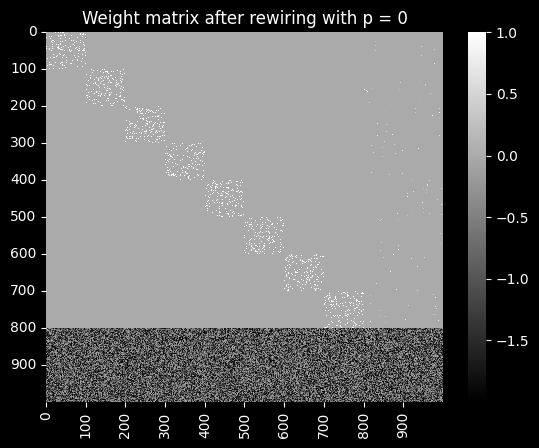

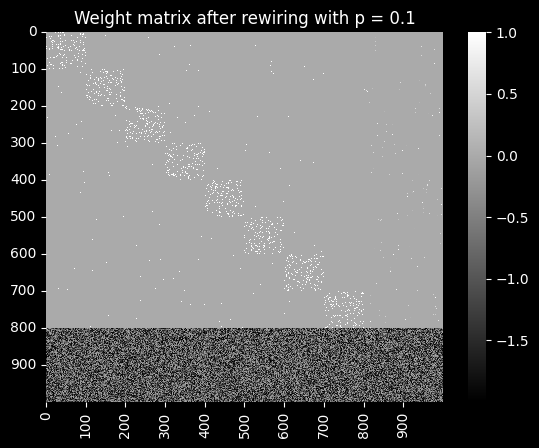

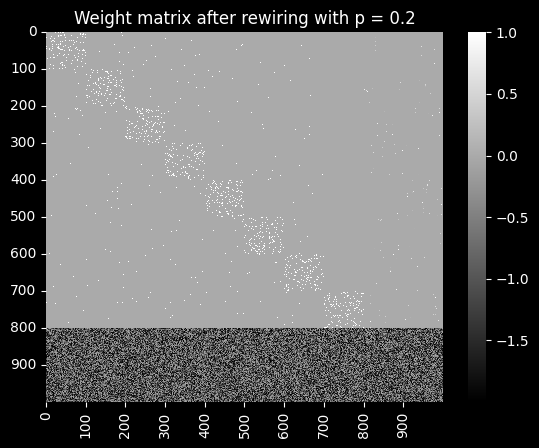

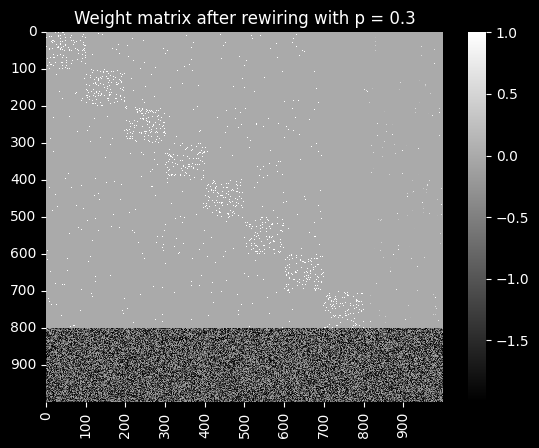

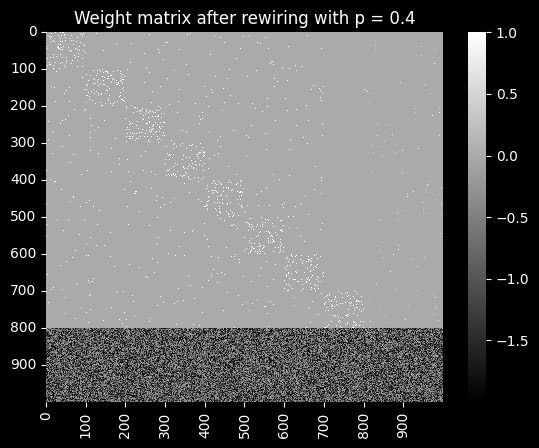

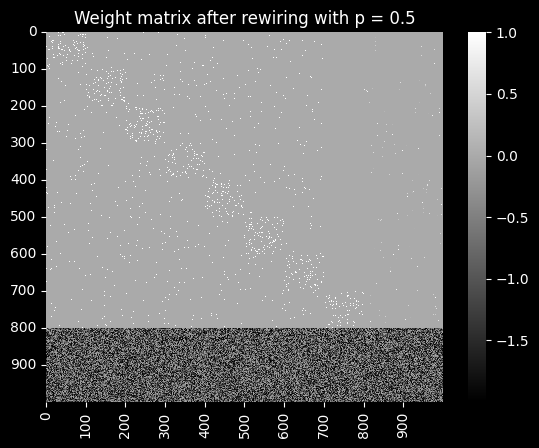

In [42]:
# visualize w as heatmap for all p

for p in Ps:
    plt.figure()
    sns.heatmap(W_p[p], cmap='gray')
    plt.xticks(np.arange(0, 1000, 100), np.arange(0, 1000, 100))
    plt.yticks(np.arange(0, 1000, 100), np.arange(0, 1000, 100))
    plt.title('Weight matrix after rewiring with p = {}'.format(p))
    plt.show()
    

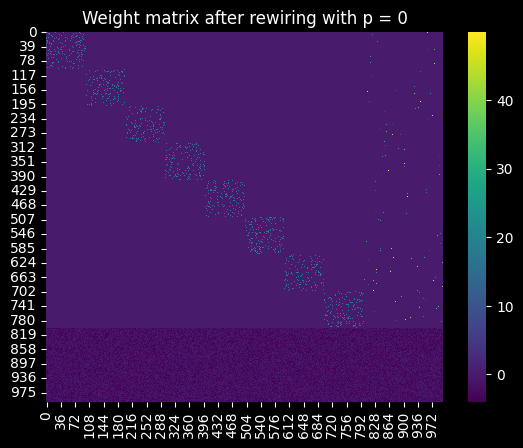

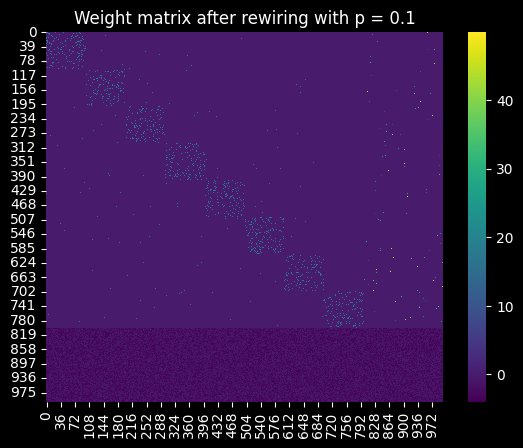

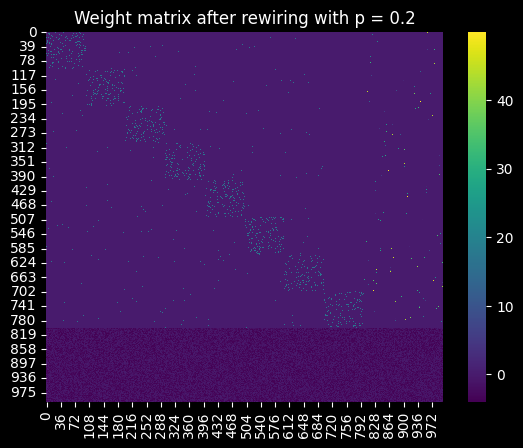

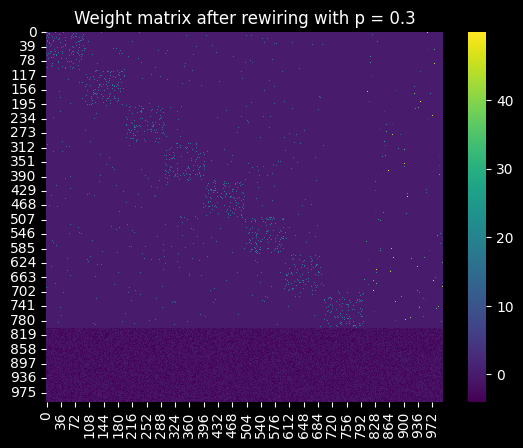

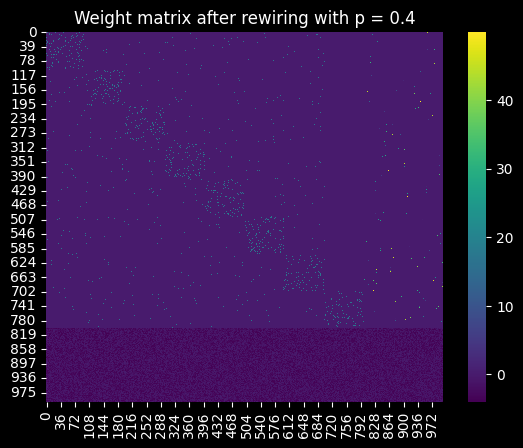

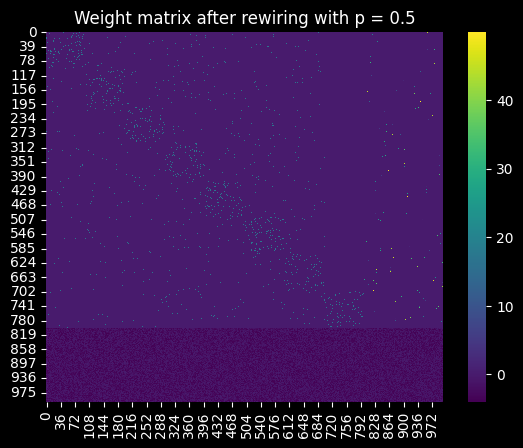

In [44]:
#Plot the weights after scaling for all p
for p in Ps:
    plt.figure()
    sns.heatmap(W_p[p], cmap='viridis')
    plt.title('Weight matrix after rewiring with p = ' + str(p))
    plt.show()

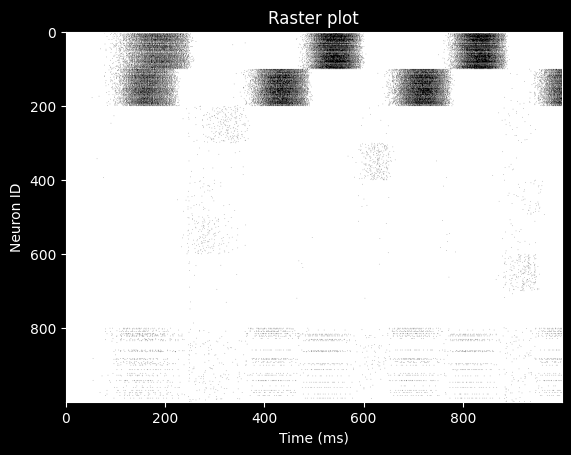

In [53]:
#raster plot
plt.figure()
plt.imshow(fired.T, aspect='auto', cmap='binary')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron ID')
plt.title('Raster plot')
plt.show()


/Users/asiabelfiore/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/asiabelfiore/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


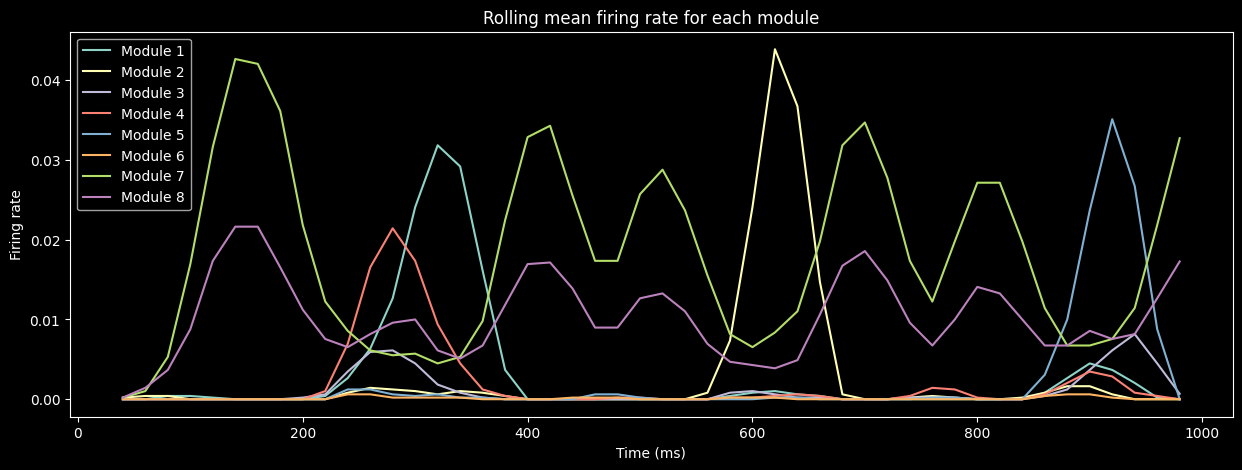

In [54]:

# Plot the rolling mean (for each module) with a window of 50ms
    #Downsample  the  firing  rates  to  obtain  the  mean  by  computing  the  average  number  of 
    #firings in 50ms windows shifted every 20ms. (This should yield 50 data points for each 
    #module.)

time_array = np.arange(0, T, 20)
plt.figure(figsize=(15, 5))

for i in range(8):
    module = np.arange(200 + i*100, 200 + i*100 + 100)
    mean_firing_rate = np.zeros(50)
    for t in range(50):
        t_real = t * 20
        mean_firing_rate[t] = np.mean(fired[t_real-24:t_real+25, module])
    plt.plot(time_array, mean_firing_rate, label='Module {}'.format(i+1))

plt.xlabel('Time (ms)')
plt.ylabel('Firing rate')
plt.title('Rolling mean firing rate for each module')
plt.legend()
plt.show()
    

